In [1]:
#importing from deepxde-0.11.2 https://github.com/lululxvi/deepxde
import sys
sys.path.insert(1, "../deepxde-0.11.2/")
import deepxde_112 as dde

#importing from deeponet-1.0.0 https://github.com/lululxvi/deeponet
sys.path.insert(1, "../deeponet-1.0.0/")
sys.path.insert(1, "../deeponet-1.0.0/src/")

from src.deeponet_pde import lt_system,ode_system,dr_system,cvc_system,advd_system,run
from src.deeponet_pde import test_u_lt,test_u_ode,test_u_dr,test_u_cvc,test_u_advd

from src.spaces import FinitePowerSeries, FiniteChebyshev, GRF
from src.system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem
from src.utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

#other imports
import itertools

import numpy as np
import tensorflow as tf
from scipy.signal import sawtooth


import matplotlib.pyplot as plt
from matplotlib import cm


# Warnings as Result of using outdated tensorflow (don't apper to be fatal)
# disabling warnings at own risk:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel('ERROR')

c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\jansp\miniconda3\envs\SciML-tf\lib\site-packages\ten

Using TensorFlow 1 backend.




In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7691445316373818070
]


# Training a DeepONet on a System

This Demo relies heavily on the DeepONet implementations offered by luluxvi (https://github.com/lululxvi).

We apply the DeepONet Network to a specific Operator/Equation System: 

    a) we select a specific architecture and the Network's dimensions

    b) we will generate input Data using e.g. Gaussian Random Fields

    c) for the input functions we will numerically calculate respective Solutions
    
    d) On this labelled Dataset we train the DeepONet and evaluate the Results

## 1. Run DeepONet

#### 1.1. Specify System

In [3]:
#specify System:
def get_system(name):
    if name == "lt":
        npoints_output = 20
        system = lt_system(npoints_output)
    elif name == "ode":
        system = ode_system(T)
    elif name == "dr":
        npoints_output = 100
        system = dr_system(T, npoints_output)
    elif name == "cvc":
        npoints_output = 100
        system = cvc_system(T, npoints_output)
    elif name == "advd":
        npoints_output = 100
        system = advd_system(T, npoints_output)
        
    return system

In [4]:
def test_sys(problem,model,data,system,T,m,space,nn):

    tests = [
        (lambda x: x, "x.dat"),
        (lambda x: np.sin(np.pi * x), "sinx.dat"),
        (lambda x: np.sin(2 * np.pi * x), "sin2x.dat"),
        (lambda x: x * np.sin(2 * np.pi * x), "xsin2x.dat"),
    ]

    for u, fname in tests:
        if problem == "lt":
            test_u_lt(nn, system, T, m, model, data, u, fname)
        elif problem == "ode":
            test_u_ode(nn, system, T, m, model, data, u, fname)
        elif problem == "dr":
            test_u_dr(nn, system, T, m, model, data, u, fname)
        elif problem == "cvc":
            test_u_cvc(nn, system, T, m, model, data, u, fname)
        elif problem == "advd":
            test_u_advd(nn, system, T, m, model, data, u, fname)


    if problem == "lt":
        features = space.random(10)
        sensors = np.linspace(0, 2, num=m)[:, None]
        u = space.eval_u(features, sensors)
        for i in range(u.shape[0]):
            test_u_lt(nn, system, T, m, model, data, lambda x: u[i], str(i) + ".dat")

    if problem == "cvc":
        features = space.random(10)
        sensors = np.linspace(0, 1, num=m)[:, None]
        # Case I Input: V(sin^2(pi*x))
        u = space.eval_u(features, np.sin(np.pi * sensors) ** 2)
        # Case II Input: x*V(x)
        # u = sensors.T * space.eval_u(features, sensors)
        # Case III/IV Input: V(x)
        # u = space.eval_u(features, sensors)
        for i in range(u.shape[0]):
            test_u_cvc(nn, system, T, m, model, data, lambda x: u[i], str(i) + ".dat")

    if problem == "advd":
        features = space.random(10)
        sensors = np.linspace(0, 1, num=m)[:, None]
        u = space.eval_u(features, np.sin(np.pi * sensors) ** 2)
        for i in range(u.shape[0]):
            test_u_advd(nn, system, T, m, model, data, lambda x: u[i], str(i) + ".dat")

We will use one of these two systems:

In [5]:
def ode_system(T):
    """ODE"""

    def g(s, u, x):
        # Antiderivative
        # return u
        # Nonlinear ODE
        return -s**2 + u
        # Gravity pendulum
        # k = 1
        # return [s[1], - k * np.sin(s[0]) + u]

    s0 = [0]
    # s0 = [0, 0]  # Gravity pendulum
    return ODESystem(g, s0, T)

def dr_system(T, npoints_output):
    """Diffusion-reaction"""
    D = 0.01
    k = 0.01
    Nt = 100
    return DRSystem(D, k, T, Nt, npoints_output)

In [6]:
# Problems:
# - "lt": Legendre transform
# - "ode": Antiderivative, Nonlinear ODE, Gravity pendulum
# - "dr": Diffusion-reaction
# - "cvc": Advection
# - "advd": Advection-diffusion

problem = "dr"
T = 1

system = get_system(problem)

#### 1.2 Define Input Function Space for Training

In [7]:
# Function space
# space = FinitePowerSeries(N=100, M=1)
# space = FiniteChebyshev(N=20, M=1)
# space = GRF(2, length_scale=0.2, N=2000, interp="cubic")  # "lt"
space = GRF(1, length_scale=0.2, N=1000, interp="cubic")
# space = GRF(T, length_scale=0.2, N=1000 * T, interp="cubic")

#### 1.3 Define Neural Net

We define the Net Architecture with 2 Layers of size 40, for both the Branch and Trunk Net - using a Unstacked Architecture.

In [8]:
# Hyperparameters
m = 100             # Nr. of sensors
num_train = 10000   # Nr. train samples
num_test =  20000   # Nr. test samples (originally 100k)
lr = 0.001
epochs = 10000      # originally 50k

# Network
nn = "opnn"
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 1 if problem in ["ode", "lt"] else 2
if nn == "opnn":
    net = dde.maps.OpNN(
        [m, 40, 40],
        [dim_x, 40, 40],
        activation,
        initializer,
        use_bias=True,
        stacked=False,
    )
elif nn == "fnn":
    net = dde.maps.FNN([m + dim_x] + [100] * 2 + [1], activation, initializer)
elif nn == "resnet":
    net = dde.maps.ResNet(m + dim_x, 1, 128, 2, activation, initializer)

#### 1.5 Generate Input Data (Gaussian Random Field)

In [9]:
# space_test = GRF(1, length_scale=0.1, N=1000, interp="cubic")

X_train, y_train = system.gen_operator_data(space, m, num_train)
X_test, y_test = system.gen_operator_data(space, m, num_test)
if nn != "opnn":
    X_train = merge_values(X_train)
    X_test = merge_values(X_test)

Generating operator data...
'gen_operator_data' took 94.647011 s

Generating operator data...
'gen_operator_data' took 184.797715 s



Optional: save and reload data to save time

(The Numerical Calculations for generating Training Data are typically the most time-consuming step)

In [10]:
# np.savez_compressed("DR_system_data/train.npz", X_train0=X_train[0], X_train1=X_train[1], y_train=y_train)
# np.savez_compressed("DR_system_data/test.npz", X_test0=X_test[0], X_test1=X_test[1], y_test=y_test)
#
# return

# d = np.load("DR_system_data/train.npz")
# X_train, y_train = (d["X_train0"], d["X_train1"]), d["y_train"]
# d = np.load("DR_system_data/test.npz")
# X_test, y_test = (d["X_test0"], d["X_test1"]), d["y_test"]

In [11]:
X_test_trim = trim_to_65535(X_test)[0]
y_test_trim = trim_to_65535(y_test)[0]
if nn == "opnn":
    data = dde.data.OpDataSet(
        X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim
    )
else:
    data = dde.data.DataSet(
        X_train=X_train, y_train=y_train, X_test=X_test_trim, y_test=y_test_trim
    )

#### 1.6 Train Model and Evaluate Results

In [12]:
model = dde.Model(data, net)
model.compile("adam", lr=lr, metrics=[mean_squared_error_outlier])
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1000
)

Compiling model...
Building operator neural network...
'build' took 0.097020 s

'compile' took 0.345096 s



Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [3.90e-01]    [3.88e-01]    [3.75e-01]    
1000      [2.24e-03]    [2.25e-03]    [2.12e-03]    
2000      [9.07e-04]    [9.18e-04]    [8.74e-04]    
3000      [5.56e-04]    [5.51e-04]    [5.34e-04]    
4000      [4.12e-04]    [4.09e-04]    [3.98e-04]    
5000      [3.12e-04]    [3.11e-04]    [3.02e-04]    
6000      [2.42e-04]    [2.43e-04]    [2.36e-04]    
7000      [2.11e-04]    [2.10e-04]    [2.05e-04]    
8000      [1.66e-04]    [1.65e-04]    [1.60e-04]    
9000      [1.50e-04]    [1.49e-04]    [1.44e-04]    
10000     [1.66e-04]    [1.60e-04]    [1.53e-04]    

Best model at step 9000:
  train loss: 1.50e-04
  test loss: 1.49e-04
  test metric: [1.44e-04]

'train' took 4313.357487 s

# Parameters: 7441
Saving loss history to c:\Users\jansp\Documents\Scientific ML\Code\Demo training\loss.dat ...
Saving training data to c:\Users\jansp\Documents\Scientific ML\Code\Demo trainin

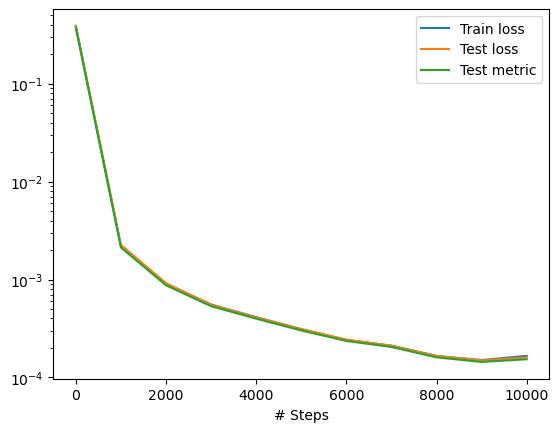

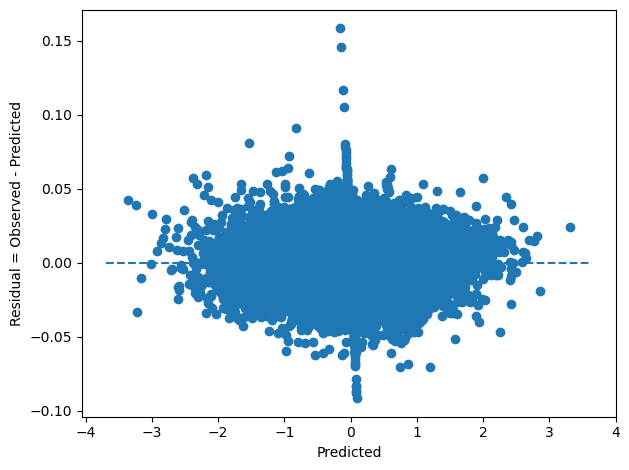

Restoring model from model/model.ckpt-9000 ...

Test MSE: 0.00015197094462580975
Test MSE w/o outliers: 0.00014575329894811744



In [ ]:
losshistory, train_state = model.train(epochs=epochs, callbacks=[checker])
print("# Parameters:", np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

model.restore("model/model.ckpt-" + str(train_state.best_step), verbose=1)
safe_test(model, data, X_test, y_test)

In [ ]:
test_sys(problem,model,data,system,T,m,space,nn)

In [ ]:
# Optional: save model
#     def save(self, save_path, protocol="tf.train.Saver", verbose=0):

model.save('./Model Backups/DeepONet_checkpoint_'+problem,verbose=1)

Epoch 10000: saving model to ./Model Backups/DeepONet_checkpoint_dr-10000 ...



In [13]:
# Optional: load model
#     restore(self, save_path, verbose=0):
model.restore('./Model Backups/DeepONet_checkpoint_'+problem+"-10000",verbose=1)

Restoring model from ./Model Backups/DeepONet_checkpoint_dr-10000 ...



## 2. Visualize Function of the trained DeepONet

In [14]:
def eval_model_ODE(system, model, func):
    sensors = np.linspace(0, T, num=m)[:, None]
    sensor_values = func(sensors)
    x = np.linspace(0, T, num=m)[:, None]
    X_test = [np.tile(sensor_values.T, (m, 1)), x]
    y_test = system.eval_s_func(func, x)
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    return sensors,sensor_values,y_test,y_pred
    
def eval_model_DR(system, model, func):
    """Evaluate Diffusion-reaction"""
    # comuputes both numerical and NN solution
    sensors = np.linspace(0, 1, num=m)
    sensor_value = func(sensors)
    s = system.eval_s(sensor_value)
    xt = np.array(list(itertools.product(range(m), range(system.Nt))))
    xt = xt * [1 / (m - 1), T / (system.Nt - 1)]
    X_test = [np.tile(sensor_value, (m * system.Nt, 1)), xt]
    y_test = s.reshape([m * system.Nt, 1])
    if nn != "opnn":
        X_test = merge_values(X_test)
    y_pred = model.predict(data.transform_inputs(X_test))
    return sensors,sensor_value,y_test,y_pred

In [15]:
func_arr = [
        lambda x: x-x+1,
        #lambda x: x,
        lambda x: np.sin(np.pi * x),
        lambda x: np.sin(2 * np.pi * x),
        lambda x: x * np.sin(2 * np.pi * x),
    ]

tests = [
    #(lambda x: x-x+1,"1"),
    (lambda x: x, "x"),
    #(lambda x: np.sin(np.pi * x), "sin(x)"),
    (lambda x: np.sin(2 * np.pi * x), "sin(2x)"),
    #(lambda x: x * np.sin(2 * np.pi * x), "x sin(2x)"),
    (lambda x: np.heaviside(x-0.5,1)-0.5, "step(x-0.5)"),
    (lambda x: 2*x - 2*x // 1-0.5, "sawtooth(2x)"),
]

<Figure size 640x480 with 0 Axes>

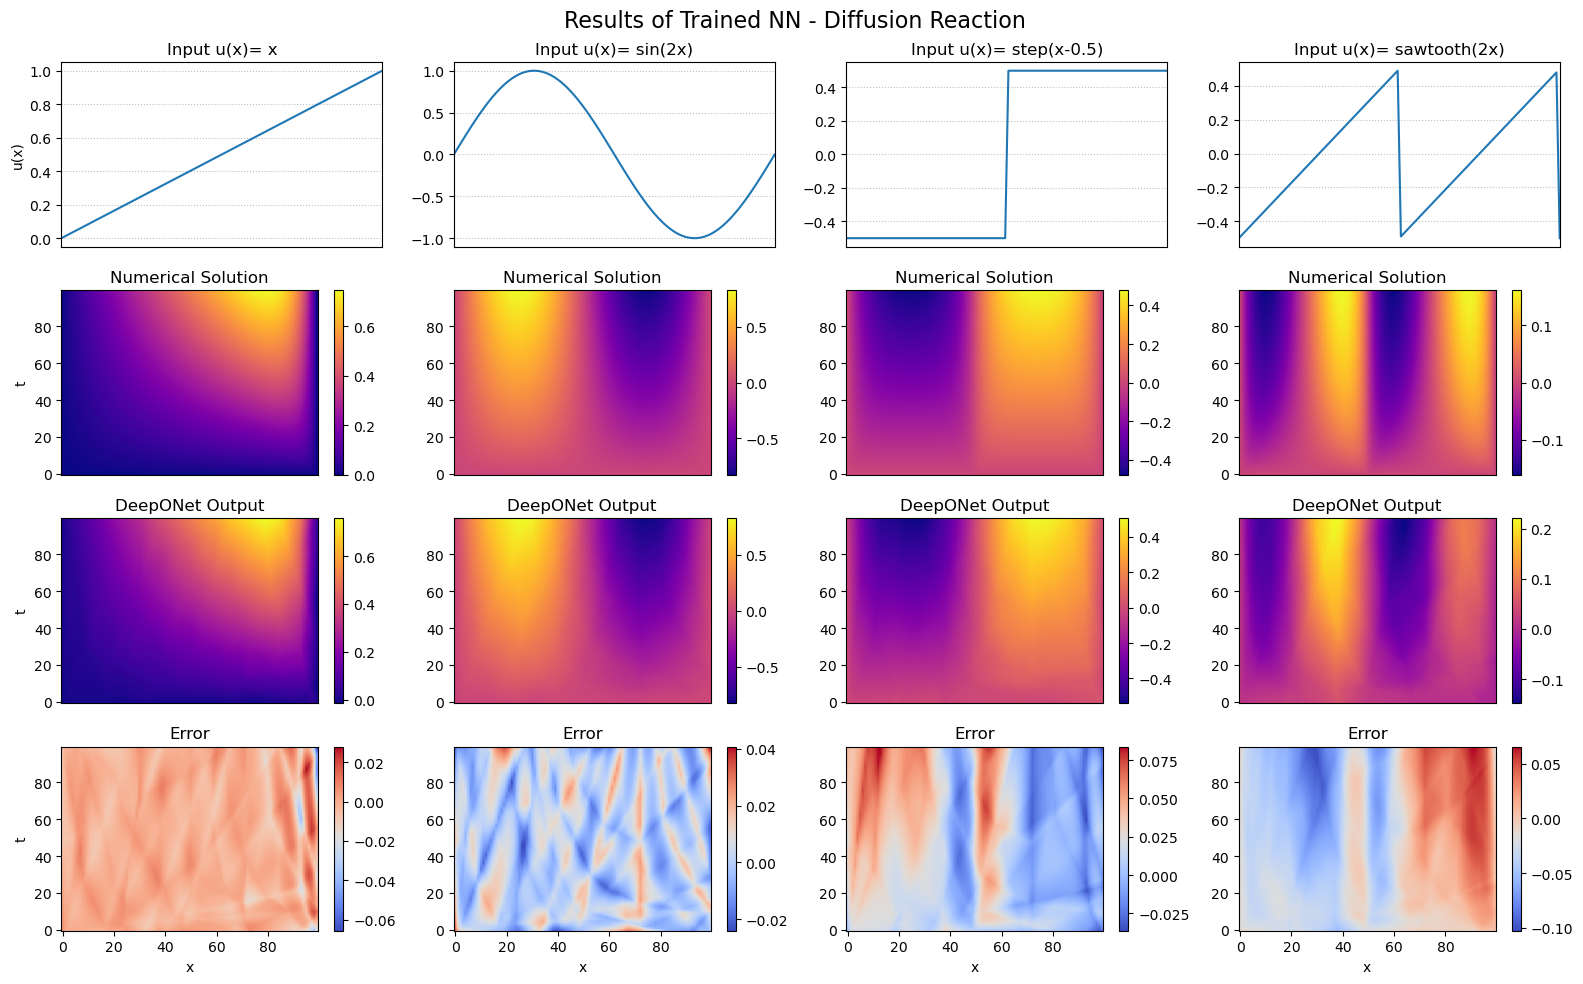

In [16]:
#Visualization for 2d / Reaction Diffusion
N=4

fig = plt.figure(1)
fig,axes =plt.subplots(4,N,figsize =(16,10))
axes =np.transpose(axes)
ax_row=axes[0]

for i,(ax_col,(func,fname)) in enumerate(zip(axes,tests)):
    x_vals,U_xvals,y_num,y_pred = eval_model_DR(system, model, func)
    #print(np.shape(x_vals),np.shape(U_xvals),np.shape(y_num),np.shape(y_pred))  
    
    ax_col[0].plot(x_vals,U_xvals, linestyle='-',label="Input Function")
    ax_col[0].set_xlim([0,1])
    ax_col[0].set_xticks([])
    if (i==0):   ax_col[0].set_ylabel("u(x)")
    #if (i==N-1): ax_col[0].legend()
    ax_col[0].set_title("Input u(x)= "+fname)
    ax_col[0].yaxis.grid(True, linestyle=':', which='major', color='grey', alpha=0.5)
    #ax.hlines(0,0,1, color='grey', linestyle=':')

    im = ax_col[1].imshow(np.transpose(y_num.reshape([m,system.Nt])),cmap='plasma',aspect='auto',origin='lower')
    ax_col[1].set_title("Numerical Solution")
    if (i==0):  ax_col[1].set_ylabel("t")
    ax_col[1].set_xticks([])
    fig.colorbar(im, ax=ax_col[1])

    im = ax_col[2].imshow(np.transpose(y_pred.reshape([m,system.Nt])),cmap='plasma',aspect='auto',origin='lower')
    ax_col[2].set_title("DeepONet Output")
    if (i==0):  ax_col[2].set_ylabel("t")
    ax_col[2].set_xticks([])
    fig.colorbar(im, ax=ax_col[2])

    
    im = ax_col[3].imshow(np.transpose(y_num.reshape([m,system.Nt])-y_pred.reshape([m,system.Nt])),cmap=cm.coolwarm,aspect='auto',origin='lower')
    ax_col[3].set_title("Error")
    if (i==0):  ax_col[3].set_ylabel("t")
    ax_col[3].set_xlabel("x")
    fig.colorbar(im, ax=ax_col[3])
    

fig.suptitle("Results of Trained NN - Diffusion Reaction",fontsize=16)
plt.tight_layout()
plt.savefig("Diffusion Reaction Results.png",dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

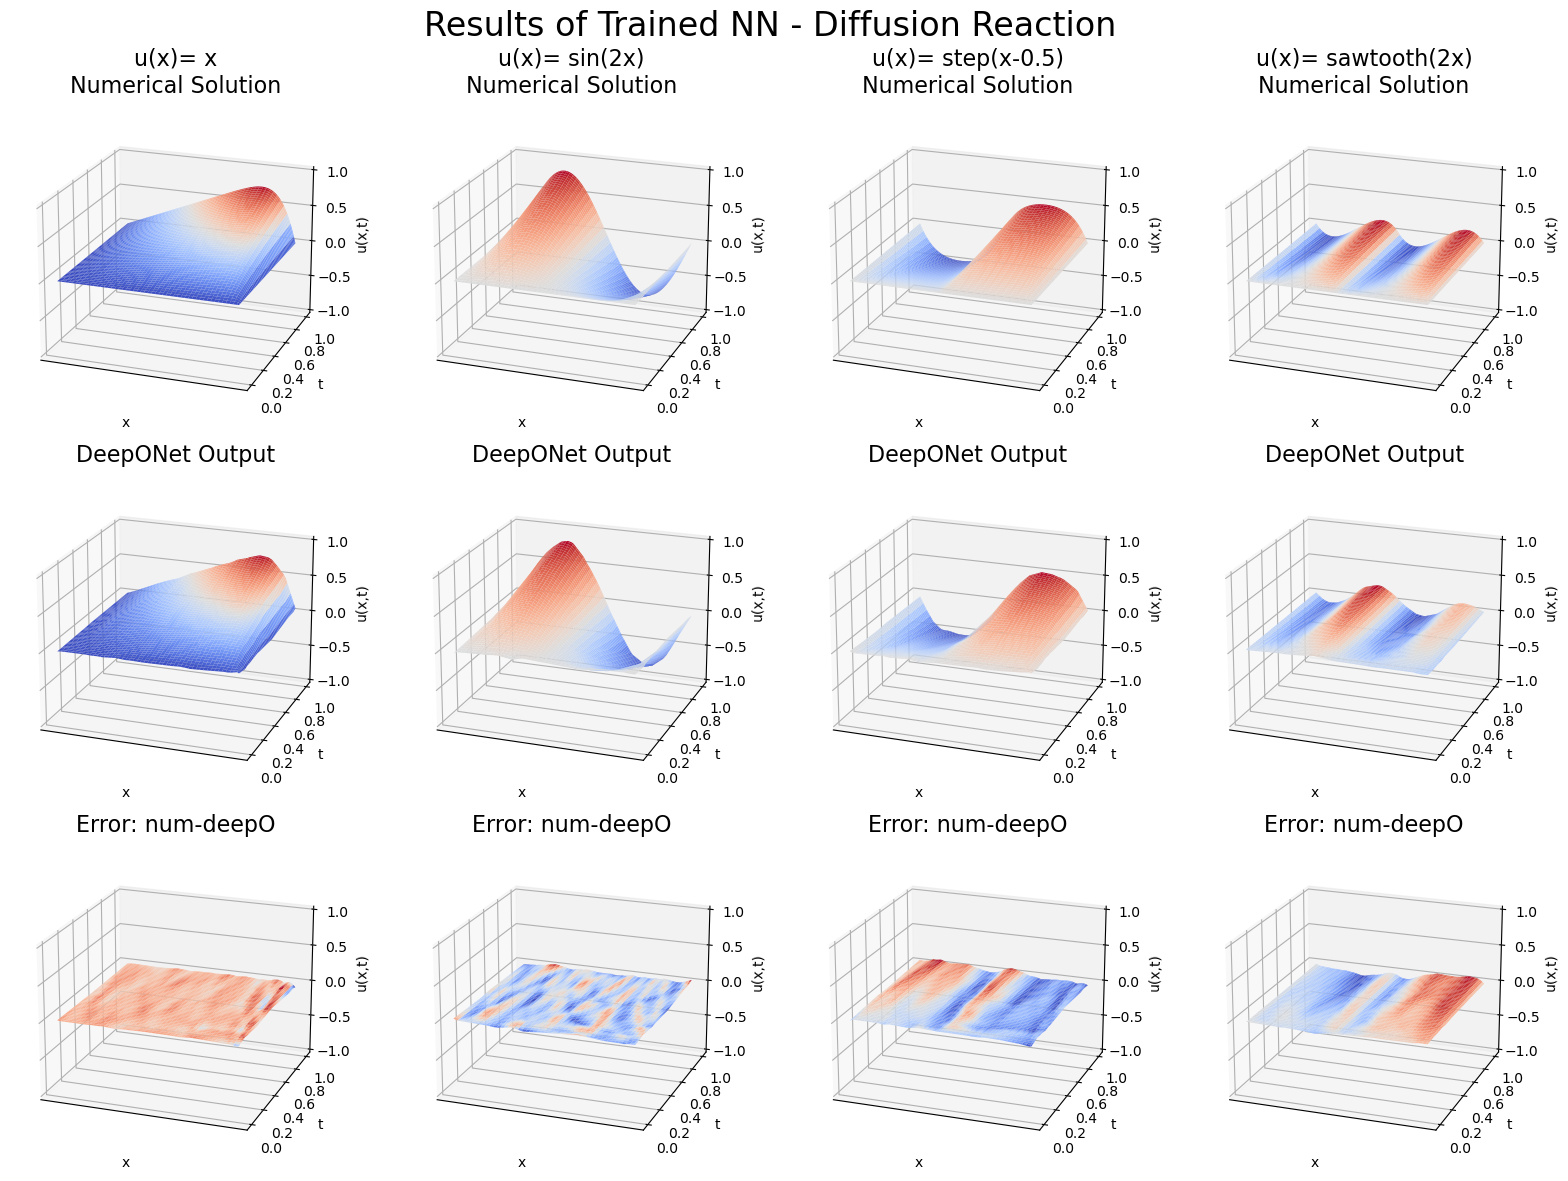

In [17]:
#Visualization for 2d / Reaction Diffusion
N=4

fig = plt.figure(1)
fig,axes =plt.subplots(3,N,figsize =(16,12),subplot_kw={"projection": "3d"})
axes =np.transpose(axes)
ax_row=axes[0]

for i,(ax_col,(func,fname)) in enumerate(zip(axes,tests)):
    x_vals,U_xvals,y_num,y_pred = eval_model_DR(system, model, func)
    #print(np.shape(x_vals),np.shape(U_xvals),np.shape(y_num),np.shape(y_pred))  
    

    ax_col[0].set_title("Input u(x)= "+fname)


    #ax_col[1] = fig.add_subplot(3, N, N+i+1, projection='3d')

    x,y = np.meshgrid(x_vals,x_vals)
    im = ax_col[0].plot_surface(x,y,np.transpose(y_num.reshape([m,system.Nt])), cmap=cm.coolwarm)
    ax_col[0].set_title("u(x)= "+fname+"\n Numerical Solution ",fontsize=16)
    ax_col[0].set_ylabel("t")
    ax_col[0].set_xlabel("x")
    ax_col[0].set_zlabel("u(x,t)")
    ax_col[0].set_xticks([])
    ax_col[0].set_zlim([-1,1])
    ax_col[0].view_init(elev=20, azim=-70)

    im = ax_col[1].plot_surface(x,y,np.transpose(y_pred.reshape([m,system.Nt])), cmap=cm.coolwarm)
    ax_col[1].set_title("DeepONet Output",fontsize=16)
    ax_col[1].set_ylabel("t")
    ax_col[1].set_xlabel("x")
    ax_col[1].set_zlabel("u(x,t)")
    ax_col[1].set_xticks([])
    ax_col[1].set_zlim([-1,1])
    ax_col[1].view_init(elev=20, azim=-70)

    im = ax_col[2].plot_surface(x,y,np.transpose((y_num.reshape([m,system.Nt])-y_pred.reshape([m,system.Nt]))), cmap=cm.coolwarm)
    ax_col[2].set_title("Error: num-deepO",fontsize=16)
    ax_col[2].set_ylabel("t")
    ax_col[2].set_xlabel("x")
    ax_col[2].set_zlabel("u(x,t)")
    ax_col[2].set_xticks([])
    ax_col[2].set_zlim([-1,1])
    ax_col[2].view_init(elev=20, azim=-70)

fig.suptitle("Results of Trained NN - Diffusion Reaction",fontsize=24)
plt.tight_layout()
plt.savefig("Diffusion Reaction Results.png",dpi=300)
plt.show()

The functions used in this Visualization are not in the space of functions used for training the DeepONet and yet the pretictions are good given the small number of training samples and epochs used.

## 3. Runtime Comparison

Comparing the Runtime of Numerical simulation vs. Inference using out treined DeepONet.

In [18]:
import time
from time import perf_counter_ns as pc

In [73]:
def runtime_NNinfer_DR(system, model, iters=1000, weighed=True):
    """Evaluate Diffusion-reaction"""
    # 1. comuputes NN solution and returns runtime
    # 2. computes numerical solution and returns runtime
    #  evaluates all points on 100x100 grid using both methods
    #  returns time taken for evaluations divided by respective number of evaluations (10000)
    #
    #  iters: number of input functions to be averaged over


    # Generating Input Functions from GRF

    # sensor_val_arr, pred_val_arr = system.gen_operator_data(space, m, iters)
    features = space.random(iters)
    sensors = np.linspace(0, 1, num=m)[:, None]
    sensor_values = space.eval_u(features, sensors)
    
    # Transforming to NN input format:
    # Need to evaluate all points on 100x100 grid
    # input values "sensor_values" are 100 space points -> add 100 time points
    xt = np.array(list(itertools.product(range(m), range(system.Nt))))
    xt = xt * [1 / (m - 1), T / (system.Nt - 1)]
    X_test = [np.tile(sensor_values[0], (m * system.Nt, 1)), xt]
    X_test_arr = [[np.tile(sensor_value, (m * system.Nt, 1)), xt] for sensor_value in sensor_values]

    #1. NN inference
    st = time.perf_counter_ns()
    y_pred = [model.predict(data.transform_inputs(X_test)) for X_test in X_test_arr]
    et = time.perf_counter_ns()

    runtime_nn = (et-st)/(100 *100 * iters) #in ns
    print(f"Runtime DeepONet inference: {runtime_nn:.3f} ns")

    #2. Numerical inference
    st = time.perf_counter_ns()
    s_values = [system.eval_s(sensor_value) for  sensor_value in sensor_values]
    et = time.perf_counter_ns()

    runtime_sim = (et-st)/(100 *100 * iters) #in ns
    if weighed:
        print(f"Runtime Numerical Sim: {runtime_sim:.3f} ns")
    return runtime_nn, runtime_sim

In [74]:
_=runtime_NNinfer_DR(system, model, iters=1000)

Runtime DeepONet inference: 277.962 ns
Runtime Numerical Sim: 885.201 ns
